In [ ]:
# ✅ Check GPU availability
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ✅ Install required libraries (run this cell if not already installed)
!pip install numpy matplotlib opencv-python scikit-learn tensorflow keras scikit-image

In [ ]:
# ✅ Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern  # Added LBP for additional feature extraction
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA  # For visualization of feature space
import time
import pandas as pd

In [ ]:
# ✅ Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()
print(f"📌 Original Dataset: Training = {X_train.shape}, Test = {X_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
📌 Original Dataset: Training = (50000, 32, 32, 3), Test = (10000, 32, 32, 3)


In [ ]:
# ----------------------------------------------------------------------------------
# NOTE: For local machine safety, we reduce the dataset size.
# You can increase these numbers (e.g., subset_size_train=5000, subset_size_test=1000)
# if your machine can handle the extra load.
subset_size_train = 1500  # Use only 1500 training images
subset_size_test = 500    # Use only 500 test images

In [ ]:
# Randomly select indices for a smaller subset
train_indices = np.random.choice(len(X_train), subset_size_train, replace=False)
test_indices = np.random.choice(len(X_test), subset_size_test, replace=False)

# Select the smaller dataset
X_train_small = X_train[train_indices]
y_train_small = y_train[train_indices]
X_test_small = X_test[test_indices]
y_test_small = y_test[test_indices]

print(f"✅ Reduced Dataset: Training = {len(X_train_small)}, Test = {len(X_test_small)}")


✅ Reduced Dataset: Training = 1500, Test = 500


In [ ]:
# ✅ Resize images AFTER dataset reduction to optimize memory usage
IMG_SIZE = 64  # ResNet50 input size (can be modified if needed)
X_train_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_train_small])
X_test_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_test_small])

print(f"✅ Resized Dataset: Training = {X_train_resized.shape}, Test = {X_test_resized.shape}")

✅ Resized Dataset: Training = (1500, 64, 64, 3), Test = (500, 64, 64, 3)


In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 FEATURE EXTRACTION: HOG (Traditional)
# ----------------------------------------------------------------------------------
def extract_hog_features(images):
    """
    Extracts Histogram of Oriented Gradients (HOG) features from images.
    Converts images to grayscale before extraction.
    """
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        feature = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)

In [ ]:
# ✅ Extract HOG features
start_time = time.time()
hog_train = extract_hog_features(X_train_resized)
hog_test = extract_hog_features(X_test_resized)
hog_time = time.time() - start_time

# ✅ Normalize HOG features
scaler_hog = StandardScaler()
hog_train = scaler_hog.fit_transform(hog_train)
hog_test = scaler_hog.transform(hog_test)

print(f"✅ HOG Feature Extraction Completed in {hog_time:.2f} seconds")

✅ HOG Feature Extraction Completed in 3.16 seconds


In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 FEATURE EXTRACTION: LBP (Traditional) - Additional Method
# ----------------------------------------------------------------------------------
def extract_lbp_features(images, P=8, R=1.0):
    """
    Extracts Local Binary Pattern (LBP) features from images.
    Converts images to grayscale and computes normalized histograms.
    """
    lbp_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, P, R, method='uniform')
        # Compute the histogram of LBP features with bins = P + 2 (for uniform patterns)
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)  # Normalize the histogram
        lbp_features.append(hist)
    return np.array(lbp_features)

In [ ]:
# ✅ Extract LBP features
start_time = time.time()
lbp_train = extract_lbp_features(X_train_resized)
lbp_test = extract_lbp_features(X_test_resized)
lbp_time = time.time() - start_time

# ✅ Normalize LBP features (if not already normalized by histogram)
scaler_lbp = StandardScaler()
lbp_train = scaler_lbp.fit_transform(lbp_train)
lbp_test = scaler_lbp.transform(lbp_test)

print(f"✅ LBP Feature Extraction Completed in {lbp_time:.2f} seconds")

✅ LBP Feature Extraction Completed in 1.45 seconds


In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 FEATURE EXTRACTION: ResNet50 (Deep Learning)
# ----------------------------------------------------------------------------------
# ✅ Load ResNet50 model without classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# We use the penultimate layer for feature extraction in our training/evaluation.
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def extract_resnet_features(images, batch_size=16):
    """
    Extracts features from images using a pre-trained ResNet50 model.
    Uses batch processing to optimize performance.
    """
    num_samples = len(images)
    features = []

    for i in range(0, num_samples, batch_size):
        batch = images[i:i+batch_size].astype('float32')  # Convert batch to float
        batch = preprocess_input(batch)  # Normalize batch using ResNet50 preprocessing
        batch_features = model.predict(batch, verbose=0)  # Extract features
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten features
        features.append(batch_features)

        # Display progress every 2*batch_size images
        if i % (batch_size * 2) == 0:
            print(f"Processed {i}/{num_samples} images...")

    return np.vstack(features)  # Combine batch results

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ✅ Extract ResNet50 features
start_time = time.time()
resnet_train = extract_resnet_features(X_train_resized, batch_size=16)
resnet_test = extract_resnet_features(X_test_resized, batch_size=16)
resnet_time = time.time() - start_time

print(f"✅ ResNet50 Feature Extraction Completed in {resnet_time:.2f} seconds (Reduced Dataset)")

Processed 0/1500 images...
Processed 32/1500 images...
Processed 64/1500 images...
Processed 96/1500 images...
Processed 128/1500 images...
Processed 160/1500 images...
Processed 192/1500 images...
Processed 224/1500 images...
Processed 256/1500 images...
Processed 288/1500 images...
Processed 320/1500 images...
Processed 352/1500 images...
Processed 384/1500 images...
Processed 416/1500 images...
Processed 448/1500 images...
Processed 480/1500 images...
Processed 512/1500 images...
Processed 544/1500 images...
Processed 576/1500 images...
Processed 608/1500 images...
Processed 640/1500 images...
Processed 672/1500 images...
Processed 704/1500 images...
Processed 736/1500 images...
Processed 768/1500 images...
Processed 800/1500 images...
Processed 832/1500 images...
Processed 864/1500 images...
Processed 896/1500 images...
Processed 928/1500 images...
Processed 960/1500 images...
Processed 992/1500 images...
Processed 1024/1500 images...
Processed 1056/1500 images...
Processed 1088/15

In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 TRAINING CLASSIFIERS ON DIFFERENT FEATURE SETS
# ----------------------------------------------------------------------------------
# Define classifiers for evaluation
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [ ]:
# Function to train and evaluate classifiers on given features
def train_and_evaluate(features_train, features_test, y_train, y_test, feature_name):
    print(f"\n🔹 --- {feature_name} Feature Extraction Results ---")
    results_list = []
    for name, clf in classifiers.items():
        start_time = time.time()
        clf.fit(features_train, y_train)
        train_time = time.time() - start_time
        y_pred = clf.predict(features_test)
        acc = accuracy_score(y_test, y_pred)
        results_list.append((feature_name, name, acc, train_time))
        print(f"\n{name} - Accuracy on {feature_name}: {acc:.4f}, Training Time: {train_time:.2f} sec")
        print(classification_report(y_test, y_pred))
    return results_list

# Train and evaluate on HOG features
results_hog = train_and_evaluate(hog_train, hog_test, y_train_small, y_test_small, "HOG")

# Train and evaluate on LBP features
results_lbp = train_and_evaluate(lbp_train, lbp_test, y_train_small, y_test_small, "LBP")

# Train and evaluate on ResNet50 features
results_resnet = train_and_evaluate(resnet_train, resnet_test, y_train_small, y_test_small, "ResNet50")

# Combine all results into a DataFrame for comparison
all_results = results_hog + results_lbp + results_resnet
results_df = pd.DataFrame(all_results, columns=["Feature Extraction", "Classifier", "Accuracy", "Training Time (s)"])

print("\n🔹 Final Comparison Table:")
print(results_df)


🔹 --- HOG Feature Extraction Results ---

Logistic Regression - Accuracy on HOG: 0.3480, Training Time: 3.57 sec
              precision    recall  f1-score   support

           0       0.38      0.37      0.37        41
           1       0.47      0.60      0.53        52
           2       0.23      0.21      0.22        62
           3       0.26      0.25      0.26        40
           4       0.27      0.31      0.29        52
           5       0.24      0.23      0.24        53
           6       0.34      0.33      0.34        51
           7       0.47      0.35      0.40        57
           8       0.45      0.37      0.41        51
           9       0.38      0.51      0.43        41

    accuracy                           0.35       500
   macro avg       0.35      0.35      0.35       500
weighted avg       0.35      0.35      0.34       500


KNN - Accuracy on HOG: 0.3360, Training Time: 0.00 sec
              precision    recall  f1-score   support

           0    

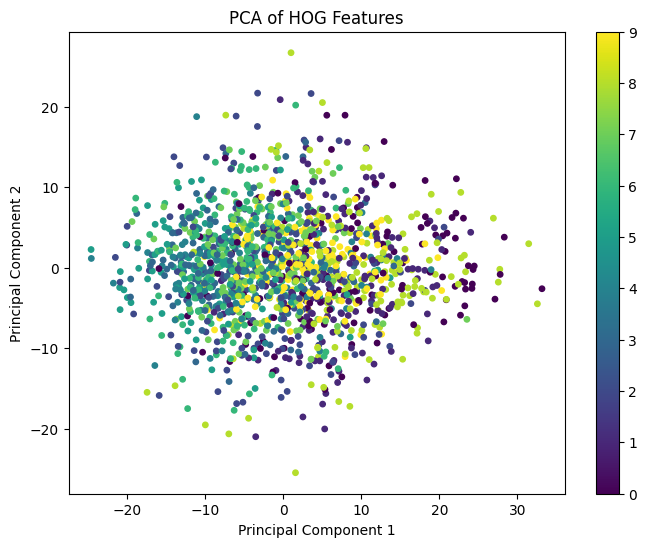

In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 PCA VISUALIZATION FOR HOG FEATURES
# ----------------------------------------------------------------------------------
pca = PCA(n_components=2)
hog_pca = pca.fit_transform(hog_train)

plt.figure(figsize=(8,6))
plt.scatter(hog_pca[:, 0], hog_pca[:, 1], c=y_train_small, cmap='viridis', s=15)
plt.title("PCA of HOG Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()


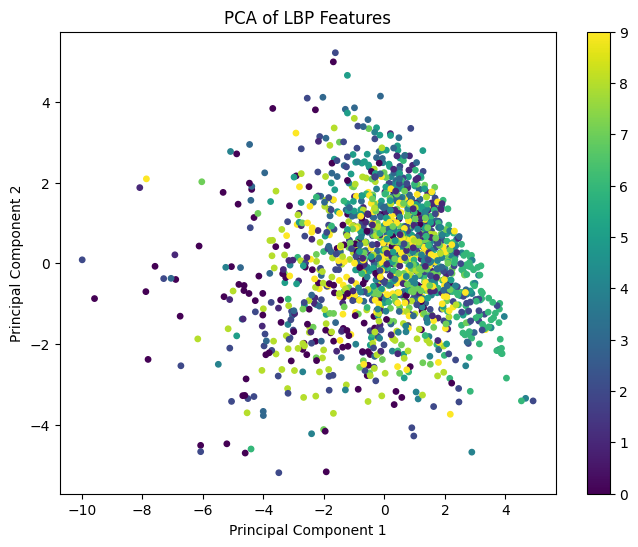

In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 PCA VISUALIZATION FOR LBP FEATURES
# ----------------------------------------------------------------------------------
pca_lbp = PCA(n_components=2)
lbp_pca = pca_lbp.fit_transform(lbp_train)

plt.figure(figsize=(8,6))
plt.scatter(lbp_pca[:, 0], lbp_pca[:, 1], c=y_train_small, cmap='viridis', s=15)
plt.title("PCA of LBP Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

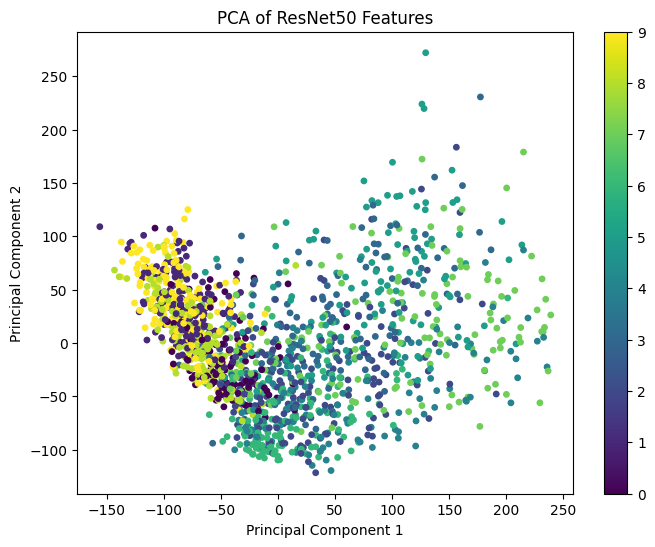

In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 PCA VISUALIZATION FOR ResNet50 FEATURES
# ----------------------------------------------------------------------------------
pca_resnet = PCA(n_components=2)
resnet_pca = pca_resnet.fit_transform(resnet_train)

plt.figure(figsize=(8,6))
plt.scatter(resnet_pca[:, 0], resnet_pca[:, 1], c=y_train_small, cmap='viridis', s=15)
plt.title("PCA of ResNet50 Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

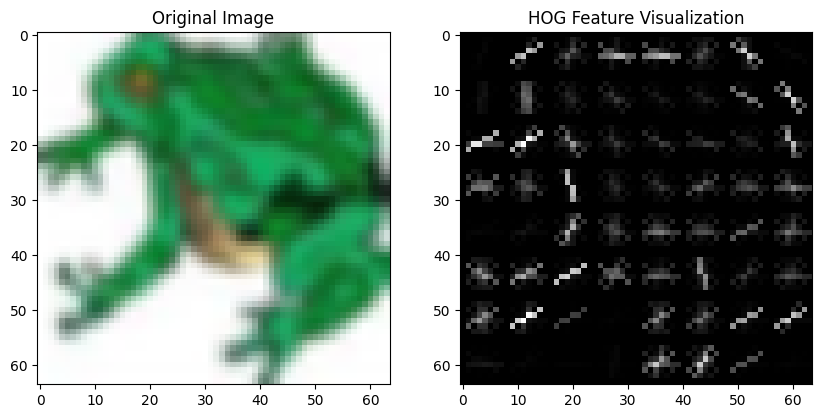

In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 HOG FEATURE VISUALIZATION ON A SAMPLE IMAGE
# ----------------------------------------------------------------------------------
# Select a sample image from the resized training set
sample_image = X_train_resized[0]
# Convert sample image to grayscale
gray = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
# Extract HOG features and visualization
hog_features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
# Plot original image and its HOG visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_image)
ax[0].set_title("Original Image")
ax[1].imshow(hog_image, cmap="gray")
ax[1].set_title("HOG Feature Visualization")
plt.show()

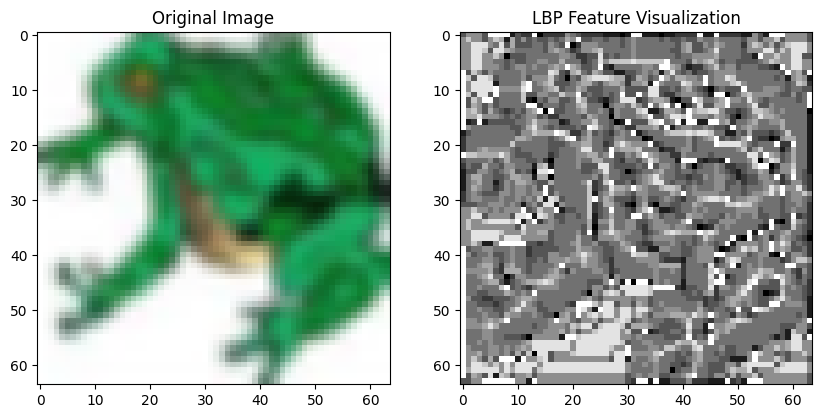

In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 LBP FEATURE VISUALIZATION ON A SAMPLE IMAGE
# ----------------------------------------------------------------------------------
# Select a sample image from the resized training set
sample_image = X_train_resized[0]
# Convert sample image to grayscale and compute LBP
gray = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
lbp_image = local_binary_pattern(gray, 8, 1.0, method='uniform')
# Plot original image and its LBP visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_image)
ax[0].set_title("Original Image")
ax[1].imshow(lbp_image, cmap="gray")
ax[1].set_title("LBP Feature Visualization")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


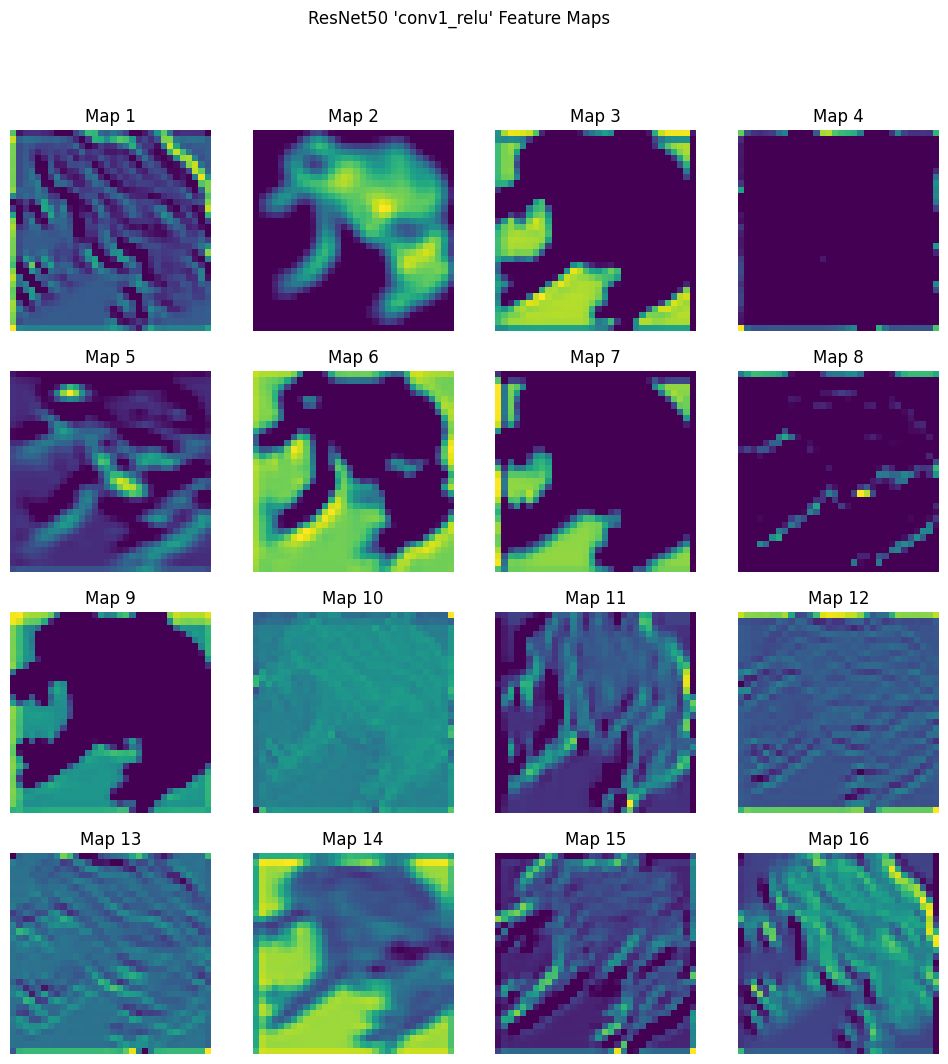

In [ ]:
# ----------------------------------------------------------------------------------
# 🔹 ResNet50 FEATURE MAP VISUALIZATION ON A SAMPLE IMAGE
# ----------------------------------------------------------------------------------
# Create a new model to extract feature maps from the 'conv1_relu' layer of ResNet50
resnet_feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer("conv1_relu").output)
# Preprocess a sample image for ResNet50
sample_image = X_train_resized[0]
sample_image_input = np.expand_dims(sample_image.astype('float32'), axis=0)
sample_image_input = preprocess_input(sample_image_input)
# Extract feature maps
feature_maps = resnet_feature_model.predict(sample_image_input)
feature_maps = feature_maps[0]  # Remove batch dimension

# Plot the first 16 feature maps in a 4x4 grid
num_feature_maps = 16
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(num_feature_maps):
    row = i // 4
    col = i % 4
    axs[row, col].imshow(feature_maps[:, :, i], cmap='viridis')
    axs[row, col].set_title(f"Map {i+1}")
    axs[row, col].axis('off')
plt.suptitle("ResNet50 'conv1_relu' Feature Maps")
plt.show()